Source:
- https://github.com/abhinavsagar/breast-cancer-classification/blob/master/Breast_cancer_classification.ipynb

## Libraries

In [1]:
import json
import math
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import tensorflow as tf
import gc
import itertools

from PIL import Image
from functools import partial
from sklearn import metrics
from collections import Counter
from keras import backend as K
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score

from keras import layers
from keras.applications import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam

In [2]:
import numpy as np
import json
import utils_nn_eval
import random
import gc
import pandas
import matplotlib.pyplot as plt
from tqdm import tqdm

from keras import backend as K
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from sklearn.metrics import cohen_kappa_score, accuracy_score

In [3]:
figure_path = 'D:/Medical_Imaging/Medical_Imaging_Elias/Figures/'

## Load Images

### Ground Truth Images

In [4]:
benign = utils_nn_eval.get_all_images('gt_benign')
malignant = utils_nn_eval.get_all_images('gt_malignant')

In [5]:
print(len(benign))
print(len(malignant))

223
301


In [6]:
random.Random(4).shuffle(benign)
random.Random(4).shuffle(malignant)

## Create Split

In [7]:
X_test, Y_test, x_train, x_val, y_train, y_val = utils_nn_eval.create_split(benign, malignant)

## Display Images

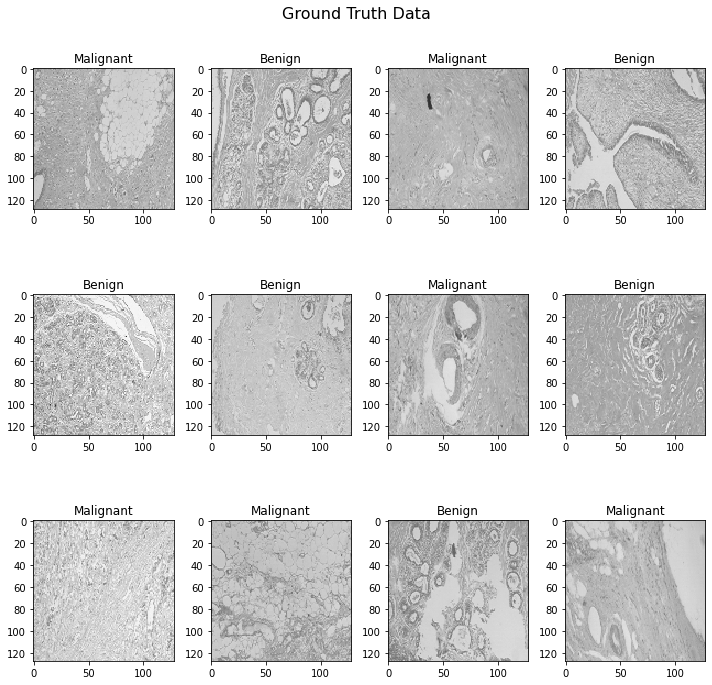

In [8]:
utils_nn_eval.display_images(x_train, y_train, "Ground Truth Data")

## Data Generator

In [9]:
train_generator = utils_nn_eval.create_train_generator()

## Model Creation

In [10]:
def build_model(backbone, lr = 1e-4):

    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation = 'softmax'))
    
    
    model.compile(
        loss = 'binary_crossentropy',
        optimizer = Adam(learning_rate = lr),
        metrics = ['accuracy']
    )
    
    return model

In [11]:
K.clear_session()
gc.collect()

shape = (128, 128, 3)

resnet = DenseNet201(
                        weights = 'imagenet',
                        include_top = False,
                        input_shape = shape
                    )

model = build_model(resnet , lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 4, 4, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 3842      
                                                                 
Total params: 18,333,506
Trainable params: 18,100,610
No

## Training & Evaluation

In [12]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath = "densenet_original_local.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [14]:
history = model.fit(

    train_generator.flow(x_train, y_train, batch_size = 16),
    steps_per_epoch=x_train.shape[0] / 16,
    epochs=4,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/4
21/20 [==============================] - ETA: 0s - loss: 0.5591 - accuracy: 0.7305
Epoch 1: val_accuracy improved from 0.57143 to 0.69048, saving model to densenet_original_local.hdf5
20/20 [==============================] - 92s 4s/step - loss: 0.5591 - accuracy: 0.7305 - val_loss: 0.5549 - val_accuracy: 0.6905 - lr: 1.0000e-04
Epoch 2/4
21/20 [==============================] - ETA: 0s - loss: 0.5498 - accuracy: 0.7365
Epoch 2: val_accuracy improved from 0.69048 to 0.72619, saving model to densenet_original_local.hdf5
20/20 [==============================] - 73s 4s/step - loss: 0.5498 - accuracy: 0.7365 - val_loss: 0.5364 - val_accuracy: 0.7262 - lr: 1.0000e-04
Epoch 3/4
21/20 [==============================] - ETA: 0s - loss: 0.5259 - accuracy: 0.7485
Epoch 3: val_accuracy improved from 0.72619 to 0.75000, saving model to densenet_original_local.hdf5
20/20 [==============================] - 73s 4s/step - loss: 0.5259 - accuracy: 0.7485 - val_loss: 0.4883 - val_accuracy: 0.75

In [29]:
with open('history_original.json', 'w') as f:
    
    json.dump(str(history.history), f)

## Prediction on Ground Truth Data

In [30]:
filepath_model = "./densenet_original_local.hdf5"
model.load_weights(filepath_model)

In [31]:
Y_val_pred = model.predict(x_val)

10/10 [==============================] - 17s 1s/step


In [32]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.796875